In [1]:
#Import the necessary libraries
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#Load dataset
df = pd.read_csv('/kaggle/input/text-js-rep/text_gen_mmn.csv')

In [3]:
df.head()

,Text,MMN_Label
0,The average household income of an individual ...,1
1,The average household income of an individual ...,0
2,The average household income of an individual ...,1
3,The average household income of an individual ...,1
4,The average household income of an individual ...,1


In [4]:
df['MMN_Label'].value_counts()

MMN_Label
1    180
0    129
Name: count, dtype: int64

<Axes: xlabel='MMN_Label', ylabel='count'>

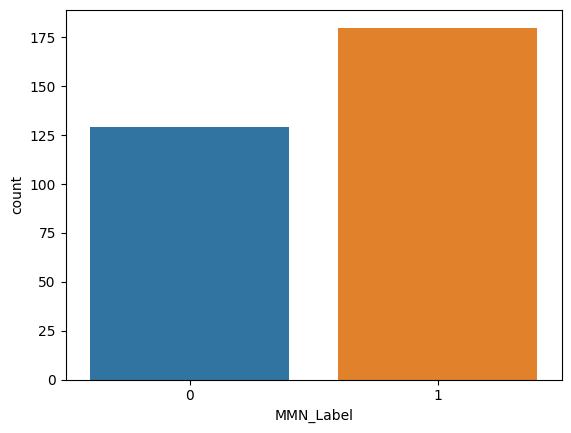

In [5]:
sns.countplot(x=df['MMN_Label'])

In [6]:
texts = df['Text'].values
labels = df['MMN_Label'].values

In [7]:
# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [8]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Load model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create Datasets and DataLoaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=512)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=512)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [11]:
# Training Loop with Early Stopping
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validation step
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    # Check early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Training finished.")

Epoch 1/20
Train Loss: 0.6907 | Validation Loss: 0.6851 | Validation Accuracy: 0.5484
Epoch 2/20
Train Loss: 0.6830 | Validation Loss: 0.6854 | Validation Accuracy: 0.5484
Epoch 3/20
Train Loss: 0.6981 | Validation Loss: 0.6690 | Validation Accuracy: 0.5484
Epoch 4/20
Train Loss: 0.6204 | Validation Loss: 0.6401 | Validation Accuracy: 0.6613
Epoch 5/20
Train Loss: 0.6163 | Validation Loss: 0.6667 | Validation Accuracy: 0.5484
Epoch 6/20
Train Loss: 0.5968 | Validation Loss: 0.5720 | Validation Accuracy: 0.7419
Epoch 7/20
Train Loss: 0.5551 | Validation Loss: 0.5664 | Validation Accuracy: 0.7419
Epoch 8/20
Train Loss: 0.5697 | Validation Loss: 0.5960 | Validation Accuracy: 0.7581
Epoch 9/20
Train Loss: 0.5311 | Validation Loss: 0.5683 | Validation Accuracy: 0.7581
Epoch 10/20
Train Loss: 0.5404 | Validation Loss: 0.6274 | Validation Accuracy: 0.7097
Early stopping triggered.
Training finished.


Accuracy: 0.7097
Precision: 0.7667
Recall: 0.6765
F1 Score: 0.7188
ROC AUC Score: 0.7784


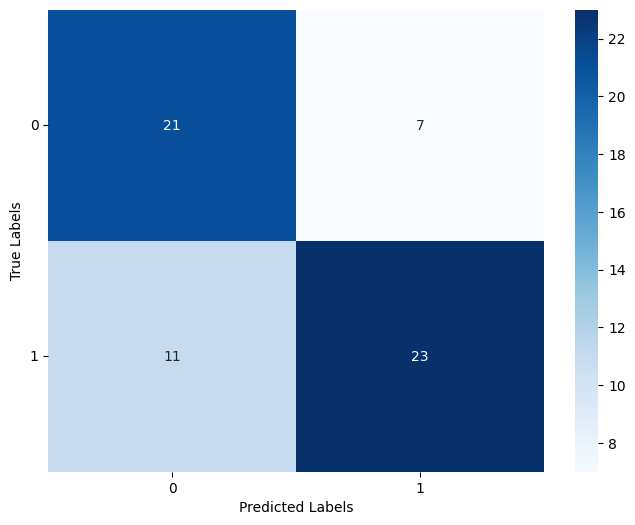

----------------------

[0.         0.03571429 0.03571429 0.10714286 0.10714286 0.14285714
 0.14285714 0.17857143 0.17857143 0.21428571 0.21428571 0.25
 0.25       0.32142857 0.32142857 0.39285714 0.39285714 0.42857143
 0.42857143 0.46428571 0.46428571 0.75       0.75       1.        ]
[0.         0.         0.17647059 0.17647059 0.32352941 0.32352941
 0.44117647 0.44117647 0.55882353 0.55882353 0.67647059 0.67647059
 0.76470588 0.76470588 0.82352941 0.82352941 0.85294118 0.85294118
 0.88235294 0.88235294 0.94117647 0.94117647 1.         1.        ]
[1.8002642  0.80026424 0.7851137  0.78090674 0.7721124  0.7700082
 0.76470923 0.7644204  0.735626   0.6499014  0.5468282  0.5033065
 0.29577267 0.23564093 0.15819691 0.14204466 0.13790408 0.13675387
 0.13286608 0.1327664  0.10711268 0.09245557 0.09148525 0.08044042]
----------------------



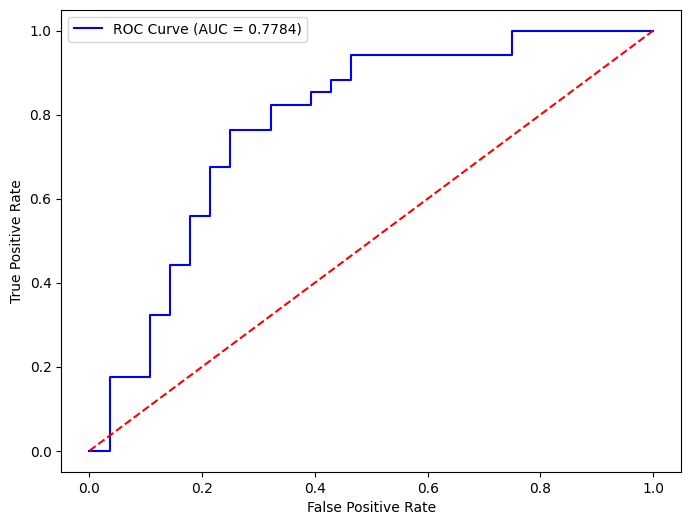

In [12]:
# Final Evaluation on Validation Set
model.eval()

all_preds = []
all_labels = []
all_probs = []

for batch in val_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        _, preds = torch.max(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_probs.extend(probs.cpu().numpy()[:, 1])  

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)

# Labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)

# Display the plot
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

print("----------------------\n")
print(fpr)
print(tpr)
print(thresholds)
print("----------------------\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()